In [94]:
# import packages:
import pandas as pd
import numpy as np
import scipy
from scipy import stats, linalg
import math
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.misc import comb
from scipy.integrate import ode

In [95]:
import holoviews as hv
import numpy as np
hv.extension('bokeh')

IOError: File widgets.js could not be found

In [96]:
# [2] define partial correlation through OLS 
# WITH OUR NEW PAPAMETER ALPHA, FOR THE INTERIM STATES BETWEEN PEARSON AND PARTIAL CORRELATION:
from scipy import stats, linalg
def partial_corr(C,alpha):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - alpha*C[:, idx].dot(beta_i)
            res_i = C[:, i] - alpha*C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

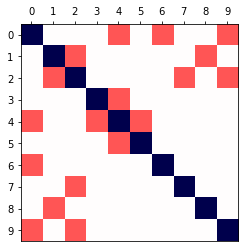

In [97]:
# [01] derive the synthetic datasets and look into the intermediate states for Pearson versus partial correlation:
# UNDIRECTED case (symmetrci adhacency matrix = mutual connections):

network_size     = 10   # number of nodes in the network
network_density  = 0.15 # fraction of all possible connections
conn_weight      = 0.33 # connectivity weight (between 0 and 1)
# generate a vector for all the upper diagonal terms:

num_comb = int(comb(network_size,2))

upper_diag = np.zeros((num_comb,1))
fc = np.zeros((network_size,network_size))

fc_vec = np.random.rand(len(upper_diag),1)
fc_vec[fc_vec > 1.0 - network_density] = 1
fc_vec[fc_vec < 1.0 - network_density] = 0

# fill in the upper triangular part of the FC matrix:
inds_upperdiag = np.triu_indices(len(fc),1)
fc[inds_upperdiag] = conn_weight*np.reshape(fc_vec, (num_comb,))
inds_lowerdiag = np.triu_indices(len(fc),-1)

# mirror upper triangular part to lower triangular:
inds_lowerdiag = np.tril_indices(len(fc),-1)
fc[inds_lowerdiag] = fc.T[inds_lowerdiag]

# introduce self-inhibition on the diagonal:
np.fill_diagonal(fc,-1)

x = np.arange(network_size)
labels = []
for ind in range(network_size):
    labels.append(str(x[ind]+1))

fig, ax = plt.subplots()
ax.imshow(fc, clim=[-1, 1], cmap='seismic')
ax.set_xticks(x)#, rotation='vertical')
ax.set_yticks(x)
ax.set_xticklabels(labels)#, rotation='vertical')
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('top')
plt.show()

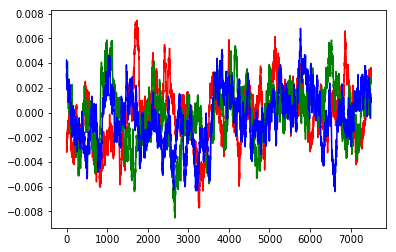

In [100]:
import numpy as np
from scipy.integrate import odeint

noise_level = 0.1  # noise level in the system
T = 100            # length of the simulation
dt = 0.01          # time step

def deriv(x, t, adjacency):
    return np.dot(adjacency, x) + noise_inputs[int(t*100),:] # + 0.0005*np.random.normal(0,1,(network_size,1))[:,0]

adjacency = fc

time = np.linspace(0, T, int(np.floor(T/dt)) + 1)
# initiate the variables at random:
x0 = -0.5*np.ones((network_size,1))[:,0] + np.random.normal(0,1,(network_size,1))[:,0]
# add noise to the system:
noise_inputs = noise_level*(-0.5*np.ones((len(time),network_size)) + np.random.rand(len(time),network_size))
synthetic_data = odeint(deriv, x0, time, args=(adjacency,))

# shorten the data by the initial 25% samples:
synthetic_data = synthetic_data[int(np.floor(len(time)*0.25)):,:]
   
plt.plot(synthetic_data[:,0],'r')
plt.plot(synthetic_data[:,1],'g')
plt.plot(synthetic_data[:,2],'b')
plt.show()

In [101]:
# compute all the values of partial correlation between 0 and 1:
alphas = 0.01*np.arange(101) # choose the range of the alpha parameter (for sliding between full Pearson and full partial corr)

interim_correlation = np.zeros((alphas.shape[0], network_size, network_size))
for ind in range(alphas.shape[0]):
    wpc = partial_corr(synthetic_data, alphas[ind])
    np.fill_diagonal(wpc,0)
    interim_correlation[ind, :, :] = wpc

In [124]:
# create a 3D interactive map of FC matrices with one slider (window number):
xticks = np.arange(network_size)
yticks = np.arange(network_size)

%opts Image (cmap='RdBu_r') [colorbar=False invert_yaxis=False xticks=xticks yticks=yticks xrotation=90]
Nwindows = alphas.shape[0]
Nvars = network_size
items_fc = {} 
for n in range(Nwindows): # a slider: window number
        def get_image3D(mat, label, n):
            mat = mat[n, :, :]
            return hv.Image(mat, label=label, bounds=[0,0,Nvars,Nvars],
                 kdims=['ROIs', 'ROIs'], 
                 vdims=[hv.Dimension('bla', range=(-0.5, 0.5))])

        image_frame = get_image3D(interim_correlation, 'between Pearson and partial correlation, ', n)
        items_fc[n] = image_frame  
        
map1 = hv.HoloMap(items_fc, kdims=['window number'])

In [125]:
# plot the output:
%output size=130 max_frames=200 
map1

:HoloMap   [window number]
   :Image   [ROIs,ROIs]   (bla)

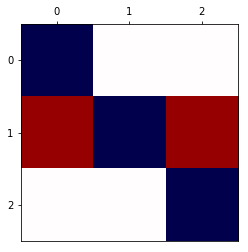

In [159]:
# [02] derive the synthetic datasets and look into the intermediate states for Pearson versus partial correlation:
# DIRECTED case (asymmetric adhacency matrix = causal connections --> we can expect Berkson's paradox to happen):
# 1 -> 2, 3 - > 2
network_size = 3
fc1 = np.zeros((network_size,network_size))
fc1[1,0] = 0.9
fc1[1,2] = 0.9
np.fill_diagonal(fc1,-1)

x = np.arange(network_size)
labels = []
for ind in range(network_size):
    labels.append(str(x[ind]))

fig, ax = plt.subplots()
ax.imshow(fc1, clim=[-1, 1], cmap='seismic')
ax.set_xticks(x)#, rotation='vertical')
ax.set_yticks(x)
ax.set_xticklabels(labels)#, rotation='vertical')
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('top')
plt.show()

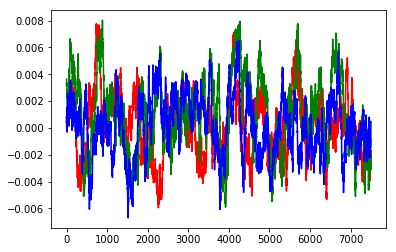

In [160]:
noise_level = 0.1  # noise level in the system
T = 100            # length of the simulation
dt = 0.01          # time step

def deriv(x, t, adjacency):
    return np.dot(adjacency, x) + noise_inputs[int(t*100),:] # + 0.0005*np.random.normal(0,1,(network_size,1))[:,0]

adjacency = fc1

time = np.linspace(0, T, int(np.floor(T/dt)) + 1)
# initiate the variables at random:
x0 = -0.5*np.ones((network_size,1))[:,0] + np.random.normal(0,1,(network_size,1))[:,0]
# add noise to the system:
noise_inputs = noise_level*(-0.5*np.ones((len(time),network_size)) + np.random.rand(len(time),network_size))
synthetic_data_causal = odeint(deriv, x0, time, args=(adjacency,))

# shorten the data by the initial 25% samples:
synthetic_data_causal = synthetic_data_causal[int(np.floor(len(time)*0.25)):,:]
   
plt.plot(synthetic_data_causal[:,0],'r')
plt.plot(synthetic_data_causal[:,1],'g')
plt.plot(synthetic_data_causal[:,2],'b')
plt.show()

In [161]:
# compute all the values of partial correlation between 0 and 1:
alphas = 0.01*np.arange(101) # choose the range of the alpha parameter (for sliding between full Pearson and full partial corr)

interim_correlation = np.zeros((alphas.shape[0], network_size, network_size))
for ind in range(alphas.shape[0]):
    wpc = partial_corr(synthetic_data_causal, alphas[ind])
    np.fill_diagonal(wpc,0)
    interim_correlation[ind, :, :] = wpc

In [162]:
# create a 3D interactive map of FC matrices with one slider (window number):
xticks = np.arange(network_size)
yticks = np.arange(network_size)

%opts Image (cmap='RdBu_r') [colorbar=False invert_yaxis=False xticks=xticks yticks=yticks xrotation=90]
Nwindows = alphas.shape[0]
Nvars = network_size
items_fc = {} 
for n in range(Nwindows): # a slider: window number
        def get_image3D(mat, label, n):
            mat = mat[n, :, :]
            return hv.Image(mat, label=label, bounds=[0,0,Nvars,Nvars],
                 kdims=['ROIs', 'ROIs'], 
                 vdims=[hv.Dimension('bla', range=(-0.5, 0.5))])

        image_frame = get_image3D(interim_correlation, 'between Pearson and partial ', n)
        items_fc[n] = image_frame  
        
map1 = hv.HoloMap(items_fc, kdims=['window number'])

In [163]:
# plot the output:
%output size=100 max_frames=200 
map1

:HoloMap   [window number]
   :Image   [ROIs,ROIs]   (bla)